# Time and Location Visualizations
**Sophia and Victoria**

In this notebook, we're going to explpore plotting tweets based on time and location!

# Importing everthing!
Let's get ready to do some cool data things!

In [1]:
% matplotlib inline
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import datetime

import cartopy.crs as ccrs
from ipywidgets import widgets
import matplotlib.cm as cm

from matplotlib import animation
from IPython.display import HTML
from tempfile import NamedTemporaryFile


/Users/Sophia/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Reading in Data
Here, we're using a function that we've developed to read in the data, a certain number of lines at a time. This uses a file of cleaned tweets that we have created but cannot push to github. 

In [2]:
def ReadToDf(linesAtATime,filepath, max=-1):
    start = time.time()
    df = pd.DataFrame()
    i = 0
    data = [] 
    
    #Open and read in the file
    with open(filepath) as cleanedTweets:
        for tweet in cleanedTweets:
            i += 1
            jsonline = json.loads(tweet)
            data.append(jsonline)
            #aggregate once we've read in the appropriate number of liens
            if (i % linesAtATime == 0):
                print "number of tweets parsed: ", i
                print "total time elapsed: ", time.time() - start
                df = df.append(pd.DataFrame(data=data))
                #reset the data
                data = []
        #Allow us to handle the last few tweets, and to truncate the data if we just want to run unit tests
            if (max > 0 and i >= max):
                break
        df = pd.DataFrame(data=data).append(df)
    #return the aggregation
    return df

In [3]:
shooting_df = ReadToDf(100000, 'data/cleanedShootingTweets.json', 200000)

number of tweets parsed:  100000
total time elapsed:  1.7647562027
number of tweets parsed:  200000
total time elapsed:  3.98646521568


In [4]:
shooting_df.head(10)

,coordinates_x,coordinates_y,created_at,entities_hashtags_text,entities_user_mentions_id_str,entities_user_mentions_screen_name,id_str,retweet_count,retweeted_status_id_str,user_id_str,user_screen_name,user_verified
0,NaN,NaN,Sun Aug 17 17:52:55 +0000 2014,[Ferguson],[],[],501064141332029440,3,None,851336634,20mUsa,True
1,NaN,NaN,Sun Aug 17 17:53:02 +0000 2014,[Ferguson],[295988417],[NerdyNegress],501064171707170816,10,501064110696857600,53158947,MzDivah67,False
2,NaN,NaN,Sun Aug 17 17:53:04 +0000 2014,[Ferguson],[295988417],[NerdyNegress],501064180468682752,10,501064110696857600,619587350,BrookLyn1825,False
3,NaN,NaN,Sun Aug 17 17:53:06 +0000 2014,[],[],[],501064188211765249,0,None,374346913,I_Mpower,False
4,NaN,NaN,Sun Aug 17 17:53:07 +0000 2014,[USNews],[],[],501064194309906436,0,None,2272978051,Vorarlberg1,False
5,NaN,NaN,Sun Aug 17 17:53:08 +0000 2014,[Ferguson],[90296594],[Thatindianbruh],501064196642340864,10479,501051914218668032,1458086762,rachel_palomera,False
6,NaN,NaN,Sun Aug 17 17:53:08 +0000 2014,"[Ferguson, MikeBrown]",[18989941],[BgRs],501064196931330049,228,501017032486178818,278298244,bookishshelly,False
7,NaN,NaN,Sun Aug 17 17:53:08 +0000 2014,[],[],[],501064197396914176,0,None,1112443196,deegerwiilen,False
8,NaN,NaN,Sun Aug 17 17:53:08 +0000 2014,"[Ferguson, tcot, uniteblue, teaparty, gop]",[],[],501064197632167936,134,501062167303450626,21811025,mmaureen7,False
9,NaN,NaN,Sun Aug 17 17:53:08 +0000 2014,"[Ferguson, CrimeButNoTime]",[935015863],[bryancrumpler],501064198009655296,5493,501011628448841728,2743004644,collettehodson,False


## Cleaning Data
This is where we're going to clean data that we've read in. The only cleaning that we need to do is that we need to convert the "created_at" column to a datetime object. The rest of the cleaning data is done in the script `development_scripts/clean_json_data.py`. 

In [18]:
def recodeData (dataframe):
    # Creating a parseable dataset    
    dataframe['createdDatetime'] =  pd.to_datetime(
        dataframe['created_at'], 
        format = '%a %b %d %H:%M:%S +0000 %Y')
    dataframe['createdDatetime_day'] = dataframe['createdDatetime'].dt.day
    dataframe['createdDatetime_hour'] = dataframe['createdDatetime'].dt.hour

Now, let's recode the dates for the shooting data and the indictment data! These opperations are done in place, so we don't actually have to return anything

In [19]:
print('recoding shooting dataset')
recodeData(shooting_df)

recoding shooting dataset


## Tweets after the Mike Brown Shooting
In the dataset related to the shooting, we have approximately 11 million tweets worth of data. Over the course of the first week, statements from police, from the family of Michael Brown, statements from the police officer Darren Wilson, and unrest from the streets were recorded and shared wildly across the web. To get a general understanding of the data, we are going to plot the number of tweets over time and annotate this plot with important events that happened over the course of the two weeks. 

First, we will group the tweets by minute, and then count the number of tweets that happened each minute. 

In [20]:
#Raw numbers of tweets over time
shootingTweetsGroupedTime = (shooting_df
                                 .set_index('createdDatetime')
                                 .groupby([pd.TimeGrouper('Min')])
                                 .count()
                                 .reset_index())

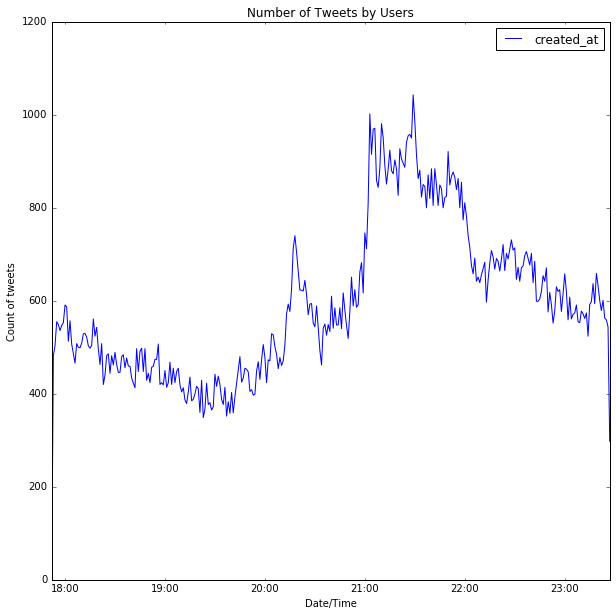

In [21]:
fig, ax = plt.subplots(figsize=(10,10))

shootingTweetsGroupedTime.plot(kind='line', x='createdDatetime', y='created_at', ax=ax)
plt.title('Number of Tweets by Users')

ax.set_ylabel('Count of tweets')
ax.set_xlabel('Date/Time')

#Overlaying Special Events
#August 11, 10AM - first police department demonstration
#August 11, 4PM - parents ask for stop to violence
#August 11, 8PM - tear gas used at protest
#August 12, 10AM - protest in St. Louis
#August 12, 12PM - Al Sharpton addresses crowds
#August 12, 4PM - Obama makes a statement
#August 13, 6PM - Reporters detained
#August 13, 9PM - Tear gas used again, and at reporters
#August 14, 7AM - Antonio French released from jail
#August 14, 11:40AM - Obama Address
#August 14, 6PM - Silent Vigils, first peaceful night
#August 15, 8:45AM - Darren Wilson names
#August 15, 12:30PM - Assassination statement by family
#August 15 Evening - Huge amounts of protest
#August 16, 3PM - State of emergency issued, curfew issued
#August 17 - Afternoon - Federal Autopsy Ordered
#August 18 - 2AM - Federal Gaurd Ordered into town
#August 18 - 3:30PM - third Obama address
#August 18 - Trayvon Martin's mother published letter
#August 19 - 7AM - family on the Today Show
#August 19 - 1PM - another man is shot
#August 22 - 12PM - national gaurd ordered to withdraw
#August 23 - Online fundraisers for officer surpass that of Brown
#August 23 - 7PM - Obama address
#August 24 - 12PM - Private Viewing, Requests for no Violence
#August 25 - Funeral

calendar_dates = {'FirstDemo':datetime(2014,8,11,10,0,0),
                 'ParentReq':datetime(2014,8,11,16,0,0),
                 'TearGas':datetime(2014,8,11,20,0,0),
                 'StLouisProtest':datetime(2014,8,12,10,0,0),
                 'AlSharpton':datetime(2014,8,12,12,0,0),
                 'Obama':datetime(2014,8,12,16,0,0),
                 'Reporters':datetime(2014,8,13,18,0,0),
                 'TearGas2':datetime(2014,8,13,21,0,0),
                 'AntonioFrench':datetime(2014,8,14,7,0,0),
                 'Obama2':datetime(2014,8,14,11,40,0),
                 'SilentVigils':datetime(2014,8,14,18,0,0),
                 'DarrenWilson':datetime(2014,8,15,8,45,0),
                 'CharacterAssassination':datetime(2014,8,15,12,30,0),
                 'StateOfEmergency':datetime(2014,8,16,15,0,0),
                 'FederalGaurd':datetime(2014,8,18,2,0,0),
                 'Obama3':datetime(2014,8,18,15,30,0),
                 'TodayShow':datetime(2014,8,19,7,0,0),
                 'AnotherShot':datetime(2014,8,19,13,0,0),
                 'GaurdWithdrawn':datetime(2014,8,22,12,0,0),
                 'Obama4':datetime(2014,8,23,19,0,0),
                 'Viewing':datetime(2014,8,24,12,0,0)}

for event in calendar_dates:
    plt.axvline(x=calendar_dates.get(event),ymin=0, ymax=4000, linewidth=4,color='g',label=event)
#     plt.text(calendar_dates.get(event),600,event)
plt.show()

Further, a certain percentage of users have place or geoencoding available on their tweets. Spatially we can see how tweets were generated following the shooting.

In [22]:
latLonPopulated = shooting_df.dropna(subset=['coordinates_x','coordinates_y'])

In [23]:
#Note, the animation code courtesy of and adapted from http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [25]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(10,10))
ax = plt.axes(xlim=(-180, 180), ylim=(-75, 75))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
scat, = plt.plot([], [],'o')

# initialization function: plot the background of each frame
def init():
    scat.set_data([], [])
    return scat,

# animation function.  This is called sequentially by the animator
def animate(i):
    day = round(i/24) + 17
    hour = i - (day-17)*24
    subset = []
    subset = latLonPopulated[
        (latLonPopulated['createdDatetime_day'] == day) & 
        (latLonPopulated['createdDatetime_hour'] == hour)]

    scat.set_data(subset.coordinates_x,subset.coordinates_y)
    
    return scat,

# animation.Animation._repr_html_ = anim_to_html #this yields a depreciation warning, heads up
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, frames=336, interval=5000, blit=True)

# call our new function to display the animation
display_animation(anim)

And over all time, statically, this looks like:

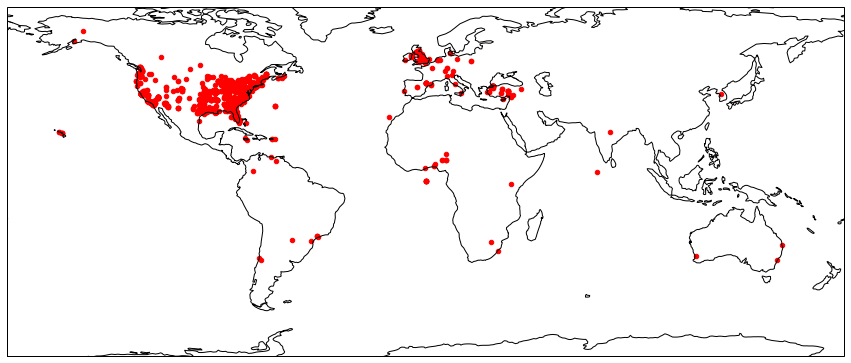

In [26]:
#the cartopy map, going simple outline for now
plt.figure(figsize=(15,15))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

#straight-up coordinate data which we just finished recoding
plt.scatter(latLonPopulated.coordinates_x,latLonPopulated.coordinates_y,color='r')
plt.axis([-180, 180, -75, 75])
plt.show()

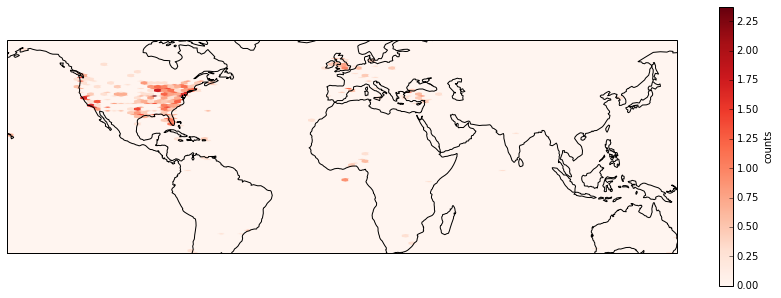

In [30]:
#as a hexbin instead
#the cartopy map, going simple outline for now
plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

#straight-up coordinate data which we just finished recoding
plt.hexbin(latLonPopulated.coordinates_x,latLonPopulated.coordinates_y,cmap=cm.Reds, bins='log') #add bins='log' to see a log based chart
cb = plt.colorbar()
cb.set_label('counts')
plt.show()

So, we can see that most of the tweets are coming from the US, expecially the East coast and Ferguson.